In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display
%matplotlib inline
import os
import torchaudio
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import datasets
import gc
import re
import soundfile as sf

2024-06-21 02:49:02.323762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 02:49:02.323898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 02:49:02.460093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/speech-accent-archive/speakers_all.csv", header=0)
print(df.shape)
df.head()

(2172, 12)


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [3]:
df.drop(df.columns[9:12],axis = 1, inplace = True)

In [4]:
df.head()
df.describe()

,age,age_onset,speakerid
count,2172.000000,2172.000000,2172.000000
mean,33.117173,8.833333,1088.449355
std,14.453039,8.451127,628.420329
min,0.000000,0.000000,1.000000
25%,22.000000,0.000000,543.750000
50%,28.000000,8.000000,1088.500000
75%,41.000000,13.000000,1632.250000
max,97.000000,86.000000,2176.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

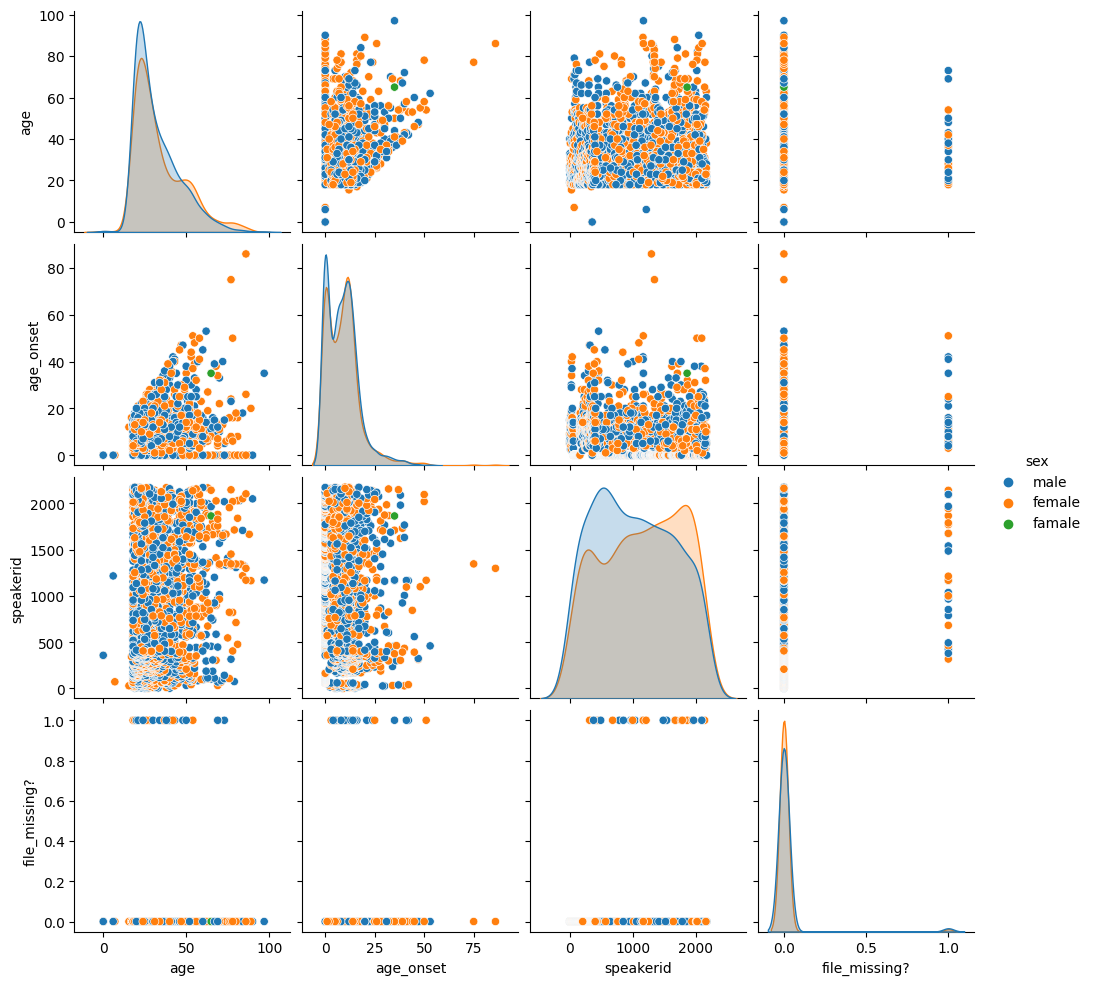

In [5]:
sns.pairplot(df,hue='sex')

In [6]:
df[df['file_missing?']==True]['age'].count()

32

In [7]:
test_rec = '/kaggle/input/speech-accent-archive/recordings/recordings/afrikaans1.mp3'
audio_data, sr = librosa.load(test_rec, sr=22000)
#audio display
ipd.Audio(audio_data, rate=sr)

In [8]:
df.isnull().sum()

age                0
age_onset          0
birthplace         4
filename           0
native_language    0
sex                0
speakerid          0
country            5
file_missing?      0
dtype: int64

In [9]:
df=df.fillna('NaN')
df.drop(df[df['file_missing?'] == True].index, inplace=True)
print(df.shape)

(2140, 9)


In [10]:
print(df['native_language'].unique())
print(df['native_language'].value_counts())

['afrikaans' 'agni' 'akan' 'albanian' 'amazigh' 'amharic' 'arabic'
 'armenian' 'ashanti' 'azerbaijani' 'bafang' 'baga' 'bai' 'bambara'
 'bamun' 'bari' 'basque' 'bavarian' 'belarusan' 'bengali' 'bosnian'
 'bulgarian' 'burmese' 'cantonese' 'carolinian' 'catalan' 'cebuano'
 'chaldean' 'chamorro' 'chichewa' 'chittagonian' 'croatian' 'czech'
 'danish' 'dari' 'dinka' 'dutch' 'ebira' 'edo' 'english' 'estonian' 'ewe'
 'fang' 'fanti' 'faroese' 'farsi' 'fataluku' 'fijian' 'filipino' 'finnish'
 'french' 'frisian' 'ga' 'gan' 'ganda' 'garifuna' 'gedeo' 'georgian'
 'german' 'greek' 'gujarati' 'gusii' 'hadiyya' 'hainanese' 'hakka' 'hausa'
 'hebrew' 'hindi' 'hindko' 'hmong' 'hungarian' 'ibibio' 'icelandic' 'ife'
 'igbo' 'ilonggo' 'indonesian' 'irish' 'italian' 'japanese' 'jola'
 'kabyle' 'kalanga' 'kambaata' 'kannada' 'kanuri' 'kazakh' 'khmer'
 'kikongo' 'kikuyu' 'kirghiz' 'kiswahili' 'konkani' 'korean' 'krio' 'kru'
 'kurdish' 'lamaholot' 'lamotrekese' 'lao' 'latvian' 'lingala'
 'lithuanian' 'luo' 'lu

In [11]:
recordings_directory = "/kaggle/input/speech-accent-archive/recordings/recordings/"
recordings_filenames = os.listdir(recordings_directory)
df['filepath'] = ""

for i, row in df.iterrows():
    filename = row['filename']
    recordings_file_path = os.path.join(recordings_directory, filename)
    df.at[i, 'filepath'] = recordings_file_path

df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,filepath
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,/kaggle/input/speech-accent-archive/recordings...
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,/kaggle/input/speech-accent-archive/recordings...
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,/kaggle/input/speech-accent-archive/recordings...
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,/kaggle/input/speech-accent-archive/recordings...
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,/kaggle/input/speech-accent-archive/recordings...


In [12]:
df['country'].value_counts().head(15)

country
usa             391
china            88
uk               67
india            58
canada           54
south korea      51
brazil           39
belgium          36
turkey           35
poland           34
australia        33
saudi arabia     33
germany          32
italy            32
ethiopia         31
Name: count, dtype: int64

In [13]:
df['native_language'].value_counts().head(15)

native_language
english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
german         36
polish         34
italian        33
japanese       27
macedonian     26
Name: count, dtype: int64

In [14]:
index_to_drop1 = df[df['filepath'] == '/kaggle/input/speech-accent-archive/recordings/recordings/nicaragua'].index
index_to_drop2 = df[df['filepath'] == '/kaggle/input/speech-accent-archive/recordings/recordings/sinhalese1'].index

df.drop(index_to_drop1, inplace=True)
df.drop(index_to_drop2, inplace=True)
df.dropna().reset_index(drop=True)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,filepath
0,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,/kaggle/input/speech-accent-archive/recordings...
1,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,/kaggle/input/speech-accent-archive/recordings...
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,/kaggle/input/speech-accent-archive/recordings...
3,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,/kaggle/input/speech-accent-archive/recordings...
4,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,/kaggle/input/speech-accent-archive/recordings...
...,...,...,...,...,...,...,...,...,...,...
2133,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,766,nigeria,False,/kaggle/input/speech-accent-archive/recordings...
2134,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,851,nigeria,False,/kaggle/input/speech-accent-archive/recordings...
2135,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,2023,nigeria,False,/kaggle/input/speech-accent-archive/recordings...
2136,31.0,1.0,"bethel, alaska, usa",yupik1,yupik,female,571,usa,False,/kaggle/input/speech-accent-archive/recordings...


MODEL _ Transformers

In [16]:
RATE_HZ = 16000
MAX_LENGTH = 128000
labels = ['english', 'spanish', 'arabic', 'french', 'mandarin', 'other']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
print(id2label, '\n\n', label2id)
gc.collect()

{0: 'english', 1: 'spanish', 2: 'arabic', 3: 'french', 4: 'mandarin', 5: 'other'} 

 {'english': 0, 'spanish': 1, 'arabic': 2, 'french': 3, 'mandarin': 4, 'other': 5}


98344

In [17]:
from pathlib import Path

lang_counter = dict()
def load_data():
    file_list = []
    label_list = []
    for file in Path('/kaggle/input/speech-accent-archive/recordings/recordings').glob('*.mp3'):
        lang = re.match(r"(\D+)", file.stem).group(1)
        if lang not in lang_counter.keys():
            lang_counter[lang] = 1
        else:
            lang_counter[lang] += 1
        # if not in our selected langs then 'other'
        if lang not in labels[:-1]:
            lang = labels[-1]
        file_list.append(file)
        label_list.append(label2id[lang])
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['label'] = label_list
    return dd

In [18]:
dd = load_data()
dd.sample(5)
dd

,file,label
0,/kaggle/input/speech-accent-archive/recordings...,1
1,/kaggle/input/speech-accent-archive/recordings...,0
2,/kaggle/input/speech-accent-archive/recordings...,2
3,/kaggle/input/speech-accent-archive/recordings...,5
4,/kaggle/input/speech-accent-archive/recordings...,5
...,...,...
2133,/kaggle/input/speech-accent-archive/recordings...,0
2134,/kaggle/input/speech-accent-archive/recordings...,5
2135,/kaggle/input/speech-accent-archive/recordings...,5
2136,/kaggle/input/speech-accent-archive/recordings...,5


In [19]:
dd['label'].value_counts()

label
5    1167
0     579
1     162
2     102
4      65
3      63
Name: count, dtype: int64

In [20]:
rus = RandomUnderSampler(random_state=83, sampling_strategy='majority')
y = dd[['label']]
dd = dd.drop(['label'], axis=1)
dd, y_resampled = rus.fit_resample(dd, y)
del y
dd['label'] = y_resampled
del y_resampled
# random oversampling of all minority classes
y = dd[['label']]
dd = dd.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
dd, y_resampled = ros.fit_resample(dd, y)
del y
dd['label'] = y_resampled
del y_resampled
gc.collect()

0

In [21]:
dd.shape, dd['label'].value_counts()

((3474, 2),
 label
 0    579
 1    579
 2    579
 3    579
 4    579
 5    579
 Name: count, dtype: int64)

In [22]:
tqdm.pandas()
def get_transform_audio(file):
    audio,rate = torchaudio.load(str(file))
    transform = torchaudio.transforms.Resample(rate,RATE_HZ)
    audio = transform(audio).squeeze(0).numpy()
    audio = audio[:MAX_LENGTH] # truncate to first part of audio to save RAM
    return audio
dd['audio'] = dd['file'].progress_apply(get_transform_audio)

100%|██████████| 3474/3474 [02:23<00:00, 24.28it/s]


In [23]:
gc.collect()

0

In [24]:
dd.iloc[10]['audio'].shape

(128000,)

In [25]:
dd = dd.drop(['file'], axis=1)

In [26]:
dd.sample(5)

,label,audio
2669,4,"[-4.1700845e-05, -8.42306e-05, -7.404936e-05, ..."
1180,1,"[0.0028382095, 0.0013611258, -0.0027549078, -0..."
1148,1,"[1.0846103e-06, -6.6370476e-06, -4.6174924e-07..."
1408,1,"[0.0006288968, 0.000884263, 0.00019790075, 0.0..."
2896,4,"[0.0004525861, 0.0007277119, 0.0009190789, 0.0..."


In [27]:
from datasets import Dataset, ClassLabel
!pip install evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [28]:
dd = Dataset.from_pandas(dd)

In [29]:
dd = dd.train_test_split(test_size=0.2)
dd

DatasetDict({
    train: Dataset({
        features: ['label', 'audio'],
        num_rows: 2779
    })
    test: Dataset({
        features: ['label', 'audio'],
        num_rows: 695
    })
})

In [30]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

model_str = "facebook/wav2vec2-base-960h" 
feature_extractor=AutoFeatureExtractor.from_pretrained(model_str)
model=AutoModelForAudioClassification.from_pretrained(model_str,num_labels=len(labels))
model.config.id2label = id2label
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


94.570118


In [31]:
dd["test"]

Dataset({
    features: ['label', 'audio'],
    num_rows: 695
})

In [32]:
def preprocess_function(batch):    
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

dd['test'] = dd['test'].map(preprocess_function, remove_columns="audio", batched=False)
dd['train'] = dd['train'].map(preprocess_function, remove_columns="audio", batched=False)

Map:   0%|          | 0/695 [00:00<?, ? examples/s]

Map:   0%|          | 0/2779 [00:00<?, ? examples/s]

In [33]:
dd["test"]
dd["train"]
gc.collect()

191

In [34]:
from sklearn.metrics import roc_auc_score
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr')
    
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }


In [38]:
from transformers import TrainingArguments, Trainer
batch_size=16
warmup_steps=50
weight_decay=0.02
num_train_epochs=10
model_name = "multiple_accent_classification"
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=3e-5,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    gradient_accumulation_steps=1, 
    gradient_checkpointing=True,
    save_strategy='epoch',
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="none",
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dd["train"],
    eval_dataset=dd["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [39]:
gc.collect()

517

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,1.324400,1.462328,0.758557,0.425899
2,1.014000,1.216502,0.836505,0.520863
3,0.959000,0.841704,0.942840,0.683453
4,0.556300,0.727307,0.941121,0.709353
5,0.563700,0.454015,0.981516,0.880576
6,1.040100,0.367211,0.986800,0.894964
7,0.371200,0.243289,0.990656,0.949640
8,0.844400,0.210557,0.993735,0.951079
9,0.143300,0.162937,0.993185,0.972662
10,0.108300,0.159783,0.992792,0.969784


TrainOutput(global_step=1740, training_loss=0.7542145432861543, metrics={'train_runtime': 5149.4518, 'train_samples_per_second': 5.397, 'train_steps_per_second': 0.338, 'total_flos': 2.01838354884096e+18, 'train_loss': 0.7542145432861543, 'epoch': 10.0})

In [41]:
trainer.evaluate()

{'eval_loss': 0.1597825288772583,
 'eval_roc_auc': 0.9927924071076566,
 'eval_accuracy': 0.9697841726618706,
 'eval_runtime': 70.5466,
 'eval_samples_per_second': 9.852,
 'eval_steps_per_second': 0.624,
 'epoch': 10.0}

In [43]:
gc.collect()
trainer.save_model()

MODEL _ 2

In [15]:
df2=df[['filepath', 'native_language']]
df2.reset_index(drop=True, inplace=True)
df2

,filepath,native_language
0,/kaggle/input/speech-accent-archive/recordings...,afrikaans
1,/kaggle/input/speech-accent-archive/recordings...,afrikaans
2,/kaggle/input/speech-accent-archive/recordings...,afrikaans
3,/kaggle/input/speech-accent-archive/recordings...,afrikaans
4,/kaggle/input/speech-accent-archive/recordings...,afrikaans
...,...,...
2133,/kaggle/input/speech-accent-archive/recordings...,yoruba
2134,/kaggle/input/speech-accent-archive/recordings...,yoruba
2135,/kaggle/input/speech-accent-archive/recordings...,yoruba
2136,/kaggle/input/speech-accent-archive/recordings...,yupik


In [16]:
df2['native_language'].value_counts().head(10)

native_language
english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
Name: count, dtype: int64

In [17]:
top_countries = ['english', 'spanish', 'arabic', 'mandarin', 'french']
df2.loc[~df2['native_language'].isin(top_countries), 'native_language'] = 'other'
df2['native_language'].value_counts()

native_language
other       1167
english      579
spanish      162
arabic       102
mandarin      65
french        63
Name: count, dtype: int64

In [18]:
RUS = RandomUnderSampler(random_state=83, sampling_strategy='majority')
y = df2[['native_language']]
df2 = df2.drop(['native_language'], axis=1)
df2, y_resampled = RUS.fit_resample(df2, y)
del y
df2['native_language'] = y_resampled
del y_resampled
# random oversampling of all minority classes
y = df2[['native_language']]
df2 = df2.drop(['native_language'], axis=1)
ROS = RandomOverSampler(random_state=83)
df2, y_resampled = ROS.fit_resample(df2, y)
del y
df2['native_language'] = y_resampled
del y_resampled
gc.collect()

101480

In [19]:
df2 = df2[df2['native_language'] != 'other']
df2['native_language'].value_counts()

native_language
arabic      579
english     579
french      579
mandarin    579
spanish     579
Name: count, dtype: int64

In [20]:
lan_map = {
    'english': 0,
    'spanish': 1,
    'arabic': 2,
    'mandarin': 3,
    'french':4,
}
df2['native_language'] = df2['native_language'].apply(lambda x: lan_map[x])

In [21]:
df2['native_language'].value_counts()

native_language
2    579
0    579
4    579
3    579
1    579
Name: count, dtype: int64

In [22]:
def trimm(data):
    data_trimmed, _ = librosa.effects.trim(data, top_db=20)
    return data_trimmed
df2

,filepath,native_language
0,/kaggle/input/speech-accent-archive/recordings...,2
1,/kaggle/input/speech-accent-archive/recordings...,2
2,/kaggle/input/speech-accent-archive/recordings...,2
3,/kaggle/input/speech-accent-archive/recordings...,2
4,/kaggle/input/speech-accent-archive/recordings...,2
...,...,...
3469,/kaggle/input/speech-accent-archive/recordings...,1
3470,/kaggle/input/speech-accent-archive/recordings...,1
3471,/kaggle/input/speech-accent-archive/recordings...,1
3472,/kaggle/input/speech-accent-archive/recordings...,1


In [26]:
def extract_features(filename):
    with sf.SoundFile(filename+'.mp3') as soundFile:
        audio = soundFile.read(dtype="float32")
        sampleRate = soundFile.samplerate
        res = np.array([])
        audio_np = np.array(audio)
        audio = trimm(audio)
        audio = librosa.effects.pitch_shift(y=audio_np, sr=sampleRate, n_steps=3)

        stft = np.abs(librosa.stft(audio))

        # for mfcc
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sampleRate, n_mfcc=13).T, axis=0)
        res = np.hstack((res, mfccs))

        # for delta
        delta_mfcc = librosa.feature.delta(mfccs)
        res = np.hstack((res, delta_mfcc))

        # for double-delta
        delta2_mfcc = librosa.feature.delta(mfccs, order=2)
        res = np.hstack((res, delta2_mfcc))

        # for mel spectrogram
        melSpec = np.mean(librosa.feature.melspectrogram(y=audio, sr=sampleRate).T, axis=0)
        res = np.hstack((res, melSpec))

    return res

In [27]:
gc.collect()

807

In [28]:
def loadData(test_size=0.2):
    x, y = [], []
    for i in tqdm(df2.index, desc="Loading Data"):
        lang = df2['native_language'][i]
        fil = df2['filepath'][i]
        
        feature = extract_features(fil)
        x.append(feature)
        y.append(lang)
        
    return train_test_split(np.array(x), y, test_size=test_size, random_state=10)

xTrain1, xTest1, yTrain1, yTest1 = loadData(test_size=0.2)
gc.collect()

Loading Data: 100%|██████████| 2895/2895 [52:56<00:00,  1.10s/it] 


55719

In [29]:
print((xTrain1.shape[0], xTest1.shape[0]))
print('Features extracted: ', xTrain1.shape[1])
print(xTrain1[0])

(2316, 579)
Features extracted:  167
[-4.73354706e+02  9.84530106e+01  4.29217625e+00  3.08512421e+01
  7.72362280e+00 -7.16856766e+00 -8.24433613e+00 -2.52633953e+01
 -1.52331686e+01 -1.17517624e+01 -1.31705875e+01 -9.78704262e+00
 -8.55233860e+00  2.33040676e+01  2.33040676e+01  2.33040676e+01
  2.33040676e+01  2.33040676e+01 -1.04598722e+01 -4.36114120e+00
 -4.02318335e+00 -1.15500236e+00 -1.15500236e+00 -1.15500236e+00
 -1.15500236e+00 -1.15500236e+00 -2.96398144e+01 -2.96398144e+01
 -2.96398144e+01 -2.96398144e+01 -2.96398144e+01  5.32157707e+00
  1.43161750e+00  3.47925758e+00  2.08516693e+00  2.08516693e+00
  2.08516693e+00  2.08516693e+00  2.08516693e+00  6.18881386e-05
  3.81903199e-04  3.22019914e-03  2.43431777e-01  1.20259392e+00
  7.44225025e-01  3.50284368e-01  3.58142942e-01  1.20350468e+00
  5.21957779e+00  5.76573372e+00  1.23120213e+00  1.45375884e+00
  2.38848090e+00  1.99178147e+00  2.09491062e+00  8.88776243e-01
  6.83473527e-01  1.11630476e+00  1.46447349e+00  9.4

In [102]:
observedLabels=['english', 'spanish', 'arabic', 'mandarin', 'french']

In [30]:
from sklearn.datasets import make_classification
from sklearn import svm

svclassifier = svm.SVC(kernel='rbf',C=0.75,gamma=0.1)
svclassifier.fit(xTrain1, yTrain1)

SVC(C=0.75, gamma=0.1)

In [31]:
ySVM = yTest1
yPredSVM = svclassifier.predict(xTest1)

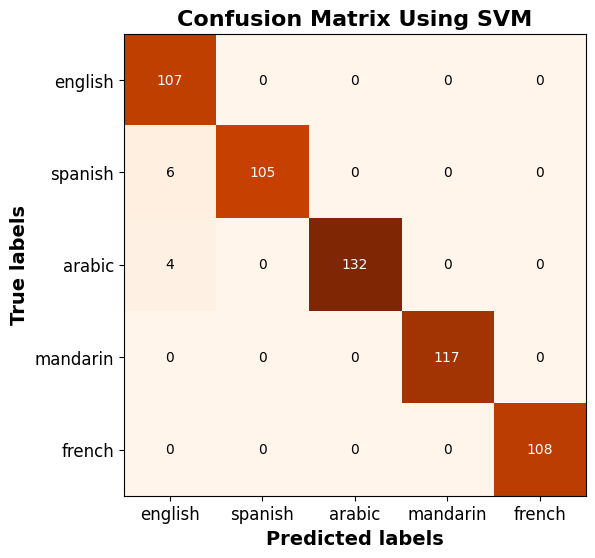

In [103]:
# confusion matrix
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = confusion_matrix(ySVM, yPredSVM)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using SVM', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
ax.yaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
plt.show()

In [33]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(ySVM, yPredSVM))
accuracy = accuracy_score(y_true=ySVM, y_pred=yPredSVM)
print('Achieved Accuracy: {:.2f}%'.format(accuracy*100))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96       107
           1       1.00      0.95      0.97       111
           2       1.00      0.97      0.99       136
           3       1.00      1.00      1.00       117
           4       1.00      1.00      1.00       108

    accuracy                           0.98       579
   macro avg       0.98      0.98      0.98       579
weighted avg       0.98      0.98      0.98       579

Achieved Accuracy: 98.27%


In [37]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = svclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(xTrain1, yTrain1)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Accuracy: 78.56 %
Best Parameters: {'C': 0.75, 'gamma': 0.1, 'kernel': 'rbf'}


In [34]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=400, criterion="gini")
rfc.fit(xTrain1, yTrain1)

RandomForestClassifier(n_estimators=400)

In [35]:
yRF = yTest1
yPredRF = rfc.predict(xTest1)

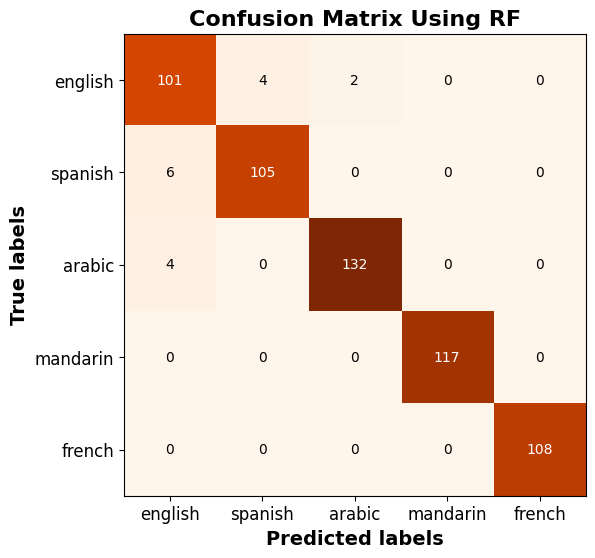

In [104]:
conf_matrix = confusion_matrix(yRF, yPredRF)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using RF', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
ax.yaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
plt.show()

In [37]:
print(classification_report(yRF, yPredRF))
accuracy = accuracy_score(y_true=yRF, y_pred=yPredRF)
print('Achieved Accuracy: {:.2f}%'.format(accuracy*100))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       107
           1       0.96      0.95      0.95       111
           2       0.99      0.97      0.98       136
           3       1.00      1.00      1.00       117
           4       1.00      1.00      1.00       108

    accuracy                           0.97       579
   macro avg       0.97      0.97      0.97       579
weighted avg       0.97      0.97      0.97       579

Achieved Accuracy: 97.24%


In [38]:
import xgboost as xgb

In [39]:
data_dmatrix = xgb.DMatrix(data=xTrain1, label=yTrain1)

In [40]:
params = {
    'objective': 'multi:softmax',  # or 'multi:softprob'
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100,
    'num_class': 6 
}

In [41]:
xg_model = xgb.XGBClassifier(**params)
xg_model.fit(xTrain1, yTrain1)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=6, ...)

In [42]:
yxgb = yTest1
yPredxgb = xg_model.predict(xTest1)

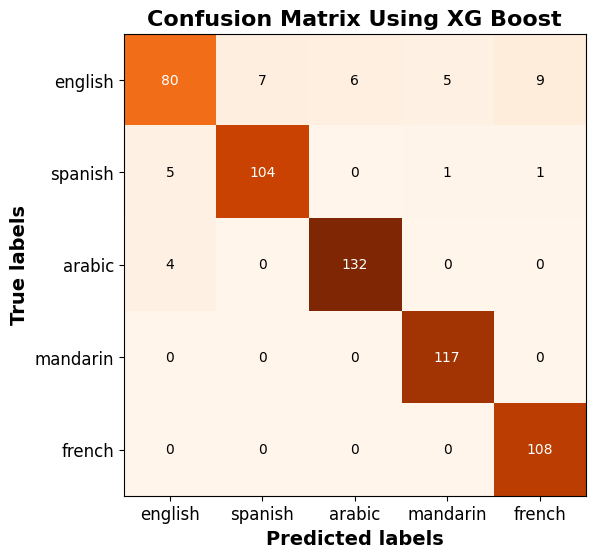

In [105]:
conf_matrix = confusion_matrix(yxgb, yPredxgb)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using XG Boost', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
ax.yaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
plt.show()

In [44]:
print(classification_report(yxgb, yPredxgb))
accuracy = accuracy_score(y_true=yxgb, y_pred=yPredxgb)
print('Achieved Accuracy: {:.2f}%'.format(accuracy*100))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       107
           1       0.94      0.94      0.94       111
           2       0.96      0.97      0.96       136
           3       0.95      1.00      0.97       117
           4       0.92      1.00      0.96       108

    accuracy                           0.93       579
   macro avg       0.93      0.93      0.93       579
weighted avg       0.93      0.93      0.93       579

Achieved Accuracy: 93.44%


In [55]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(xTrain1, yTrain1)

KNeighborsClassifier()

In [56]:
yExpectedKNN = yTest1
yPredKNN = neigh.predict(xTest1)

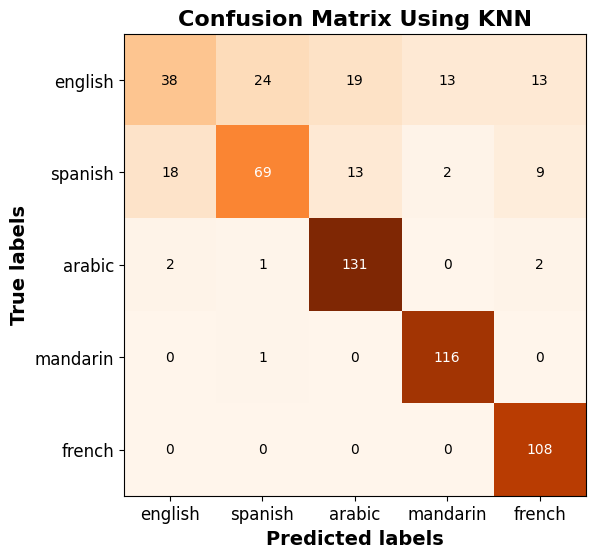

In [106]:
conf_matrix = confusion_matrix(yExpectedKNN, yPredKNN)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using KNN', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
ax.yaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
plt.show()

In [60]:
print(classification_report(yExpectedKNN, yPredKNN))
accuracy = accuracy_score(y_true=yxgb, y_pred=yPredxgb)
print('Achieved Accuracy: {:.2f}%'.format(accuracy*100))

              precision    recall  f1-score   support

           0       0.66      0.36      0.46       107
           1       0.73      0.62      0.67       111
           2       0.80      0.96      0.88       136
           3       0.89      0.99      0.94       117
           4       0.82      1.00      0.90       108

    accuracy                           0.80       579
   macro avg       0.78      0.79      0.77       579
weighted avg       0.78      0.80      0.78       579

Achieved Accuracy: 93.44%


In [61]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model  = GradientBoostingClassifier()
gbc_model.fit(xTrain1,yTrain1)

GradientBoostingClassifier()

In [62]:
ygbc = yTest1
yPredgbc = gbc_model.predict(xTest1)

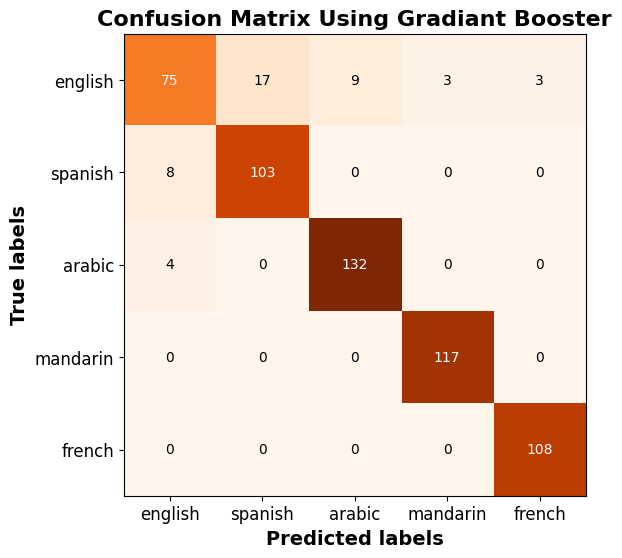

In [107]:
conf_matrix = confusion_matrix(ygbc, yPredgbc)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Oranges)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using Gradiant Booster', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
ax.yaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
plt.show()

In [64]:
print(classification_report(ygbc, yPredgbc))
accuracy = accuracy_score(y_true=yxgb, y_pred=yPredxgb)
print('Achieved Accuracy: {:.2f}%'.format(accuracy*100))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       107
           1       0.86      0.93      0.89       111
           2       0.94      0.97      0.95       136
           3       0.97      1.00      0.99       117
           4       0.97      1.00      0.99       108

    accuracy                           0.92       579
   macro avg       0.92      0.92      0.92       579
weighted avg       0.92      0.92      0.92       579

Achieved Accuracy: 93.44%


parameters cnn

In [84]:
batch_size = 64
no_epochs = 150
n_features = 167
n_testsize = 320
n_classes = 5
verbosity = 1

In [85]:
xTrainCNN1 = [x for x in xTrain1]
xTrainCNN1 = np.array(xTrainCNN1)
xTrainCNN1.shape

(2316, 167)

In [86]:
xTrainCNN1 = np.expand_dims(xTrainCNN1, -1)
xTrainCNN1.shape

(2316, 167, 1)

In [87]:
yTrainCNN1 = np.expand_dims(yTrain1, -1)
yTrainCNN1.shape

(2316, 1)

In [88]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

yTrainCNN1 = enc.fit_transform(yTrainCNN1)
yTrainCNN1 = yTrainCNN1.toarray()
yTrainCNN1.shape

(2316, 5)

In [89]:
xTestCNN1 = [x for x in xTest1]
xTestCNN1 = np.array(xTestCNN1)
xTestCNN1 = np.expand_dims(xTestCNN1, -1)

yTestCNN1 = np.expand_dims(yTest1, -1)
yTestCNN1 = enc.fit_transform(yTestCNN1)
yTestCNN1 = yTestCNN1.toarray()

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization

modelCNN = keras.Sequential([
    Conv1D(128, 8, activation='relu', input_shape=(167, 1)),
    MaxPooling1D(pool_size=(2)),
    BatchNormalization(),
    Conv1D(64, 8, activation='relu'),
    MaxPooling1D(pool_size=(2)),
    BatchNormalization(),
    Conv1D(64, 8, activation='relu', input_shape=(167, 1)),
    MaxPooling1D(pool_size=(2)),
    BatchNormalization(),
    Dropout(0.1),
    Conv1D(32, 8, activation='relu'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.3),
    Flatten(),
    Dense(n_classes, activation='softmax'),
])
modelCNN.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

modelCNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 160, 128)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 80, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 73, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 36, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 29, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 7, 32)          │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,509 (459.02 KB)

 Trainable params: 116,997 (457.02 KB)

 Non-trainable params: 512 (2.00 KB)

In [91]:
# Train the model
historyCNN = modelCNN.fit(xTrainCNN1, yTrainCNN1, batch_size=batch_size, epochs=no_epochs, verbose=verbosity, validation_data=(xTestCNN1,yTestCNN1))

Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2146 - loss: 1.8310 - val_accuracy: 0.2228 - val_loss: 1.6129
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2499 - loss: 1.5950 - val_accuracy: 0.3178 - val_loss: 1.5591
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2888 - loss: 1.5527 - val_accuracy: 0.3212 - val_loss: 1.5436
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3230 - loss: 1.5122 - val_accuracy: 0.3592 - val_loss: 1.5399
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3264 - loss: 1.4938 - val_accuracy: 0.3955 - val_loss: 1.4863
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3611 - loss: 1.4501 - val_accuracy: 0.3921 - val_loss: 1.4386
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4374 - loss: 1.3743 - val_accuracy: 0.3938 - val_loss: 1.3847
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4309 - loss: 1.3347 - val_accuracy: 0.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


NameError: name 'observedLabels' is not defined

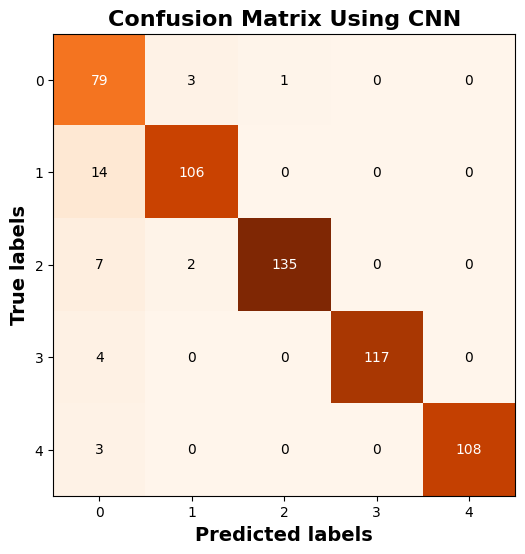

In [92]:
yExpected = yTestCNN1
yExpected = yExpected.argmax(1)
yPred = modelCNN.predict(xTestCNN1)
yPred=yPred.argmax(1)

conf_matrix = confusion_matrix(yPred,yExpected)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Oranges)
ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using CNN', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
ax.yaxis.set_ticklabels([''] + observedLabels, fontsize=12,color='black')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


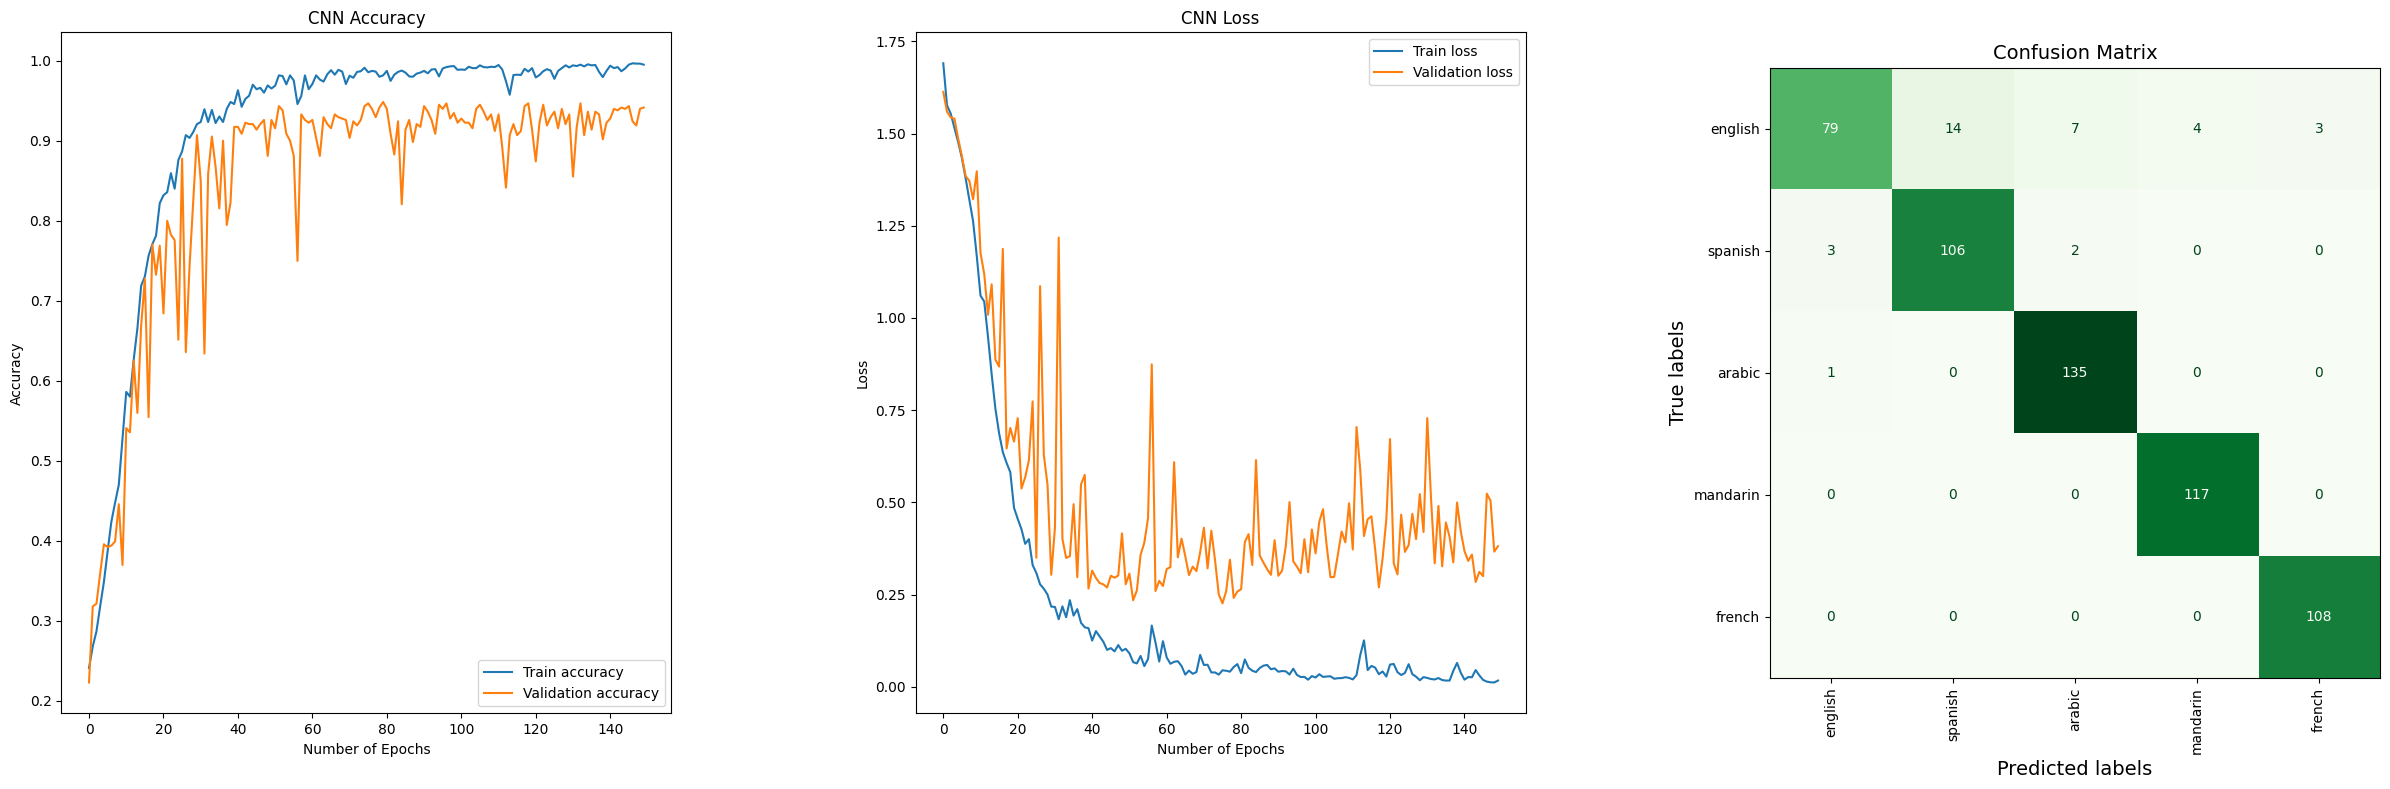

In [99]:
 from sklearn.metrics import ConfusionMatrixDisplay
# plt_epochs = list(range(150))

# #Calculating the accuracy
# acc = historyCNN.history['accuracy']
# val_acc = historyCNN.history['val_accuracy']

# #Calculating the loss
# loss = historyCNN.history['loss']
# val_loss = historyCNN.history['val_loss']

# #setting the size of the figures
# fig, ax = plt.subplots(1,3,figsize=(50, 20))

# #plotting the accuracy
# ax[0].plot(plt_epochs, acc, label='Train accuracy')
# ax[0].plot(plt_epochs, val_acc, label='Validation accuracy')
# ax[0].set_xlabel('Number of Epochs')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_title('CNN')
# ax[0].legend()
# ax[0].legend(prop={'size': 8})
# ax[0].grid(False)
# #plotting the loss
# ax[1].plot(plt_epochs, loss, label='Train loss')
# ax[1].plot(plt_epochs, val_loss, label='Validation loss')
# ax[1].set_xlabel('Number of Epochs')
# ax[1].set_ylabel('Loss')
# ax[1].set_title('CNN')
# ax[1].legend()
# ax[1].legend(prop={'size': 8})
# ax[1].grid(False)
# # confusion matrix
# yCNN1 = yTestCNN1
# yCNN1 = yCNN1.argmax(1)
# yPredCNN1 = modelCNN.predict(xTestCNN1)
# yPredCNN1=yPredCNN1.argmax(1)

# conf_matrix = confusion_matrix(yPredCNN1,yCNN1)
# disp = ConfusionMatrixDisplay(conf_matrix,display_labels=['english','spanish','arabic','mandarian','french'])
# disp.plot(ax=ax[2], xticks_rotation='vertical', cmap='Greens', values_format='.0f', colorbar=None)
# # disp.im_.colorbar.remove()
# plt.grid(False)
# fig = disp.ax_.get_figure()
# fig.set_figwidth(1)
# fig.set_figheight(4.4)
# ax[2].set_xlabel('Predicted labels', fontsize=14)
# ax[2].set_ylabel('True labels', fontsize=14)
# ax[2].set_title('Confusion Matrix', fontsize=14)
# plt.subplots_adjust(hspace=3.5, wspace=0.57)
# ax1 = ax[1].get_position()
# ax2 = ax[2].get_position()
# ax[1].set_position([0.43,ax1.y0,ax1.width,ax1.height])
# ax[2].set_position([.72,ax2.y0,.35,.8])
# plt.show()

plt_epochs = list(range(150))

# Calculating the accuracy and loss
acc = historyCNN.history['accuracy']
val_acc = historyCNN.history['val_accuracy']
loss = historyCNN.history['loss']
val_loss = historyCNN.history['val_loss']

# Setting the size of the figures
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Plotting the accuracy
ax[0].plot(plt_epochs, acc, label='Train accuracy')
ax[0].plot(plt_epochs, val_acc, label='Validation accuracy')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('CNN Accuracy')
ax[0].legend()
ax[0].legend(prop={'size': 10})
ax[0].grid(False)

# Plotting the loss
ax[1].plot(plt_epochs, loss, label='Train loss')
ax[1].plot(plt_epochs, val_loss, label='Validation loss')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('CNN Loss')
ax[1].legend()
ax[1].legend(prop={'size': 10})
ax[1].grid(False)

# Confusion matrix
yCNN1 = yTestCNN1.argmax(axis=1)
yPredCNN1 = modelCNN.predict(xTestCNN1).argmax(axis=1)

conf_matrix = confusion_matrix(yCNN1, yPredCNN1)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['english', 'spanish', 'arabic', 'mandarin', 'french'])
disp.plot(ax=ax[2], xticks_rotation='vertical', cmap='Greens', values_format='.0f', colorbar=False)

ax[2].set_xlabel('Predicted labels', fontsize=14)
ax[2].set_ylabel('True labels', fontsize=14)
ax[2].set_title('Confusion Matrix', fontsize=14)

# Adjust layout to avoid overlap
fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.4)

plt.show()


In [100]:
print(classification_report(yCNN1, yPredCNN1))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       107
           1       0.88      0.95      0.92       111
           2       0.94      0.99      0.96       136
           3       0.97      1.00      0.98       117
           4       0.97      1.00      0.99       108

    accuracy                           0.94       579
   macro avg       0.94      0.94      0.94       579
weighted avg       0.94      0.94      0.94       579

